In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint
import importlib
import utils_markov
import utils_threshold
import utils_rounding

# Markov Model

In [3]:
datain = pd.read_csv("datasets/csv6.csv")
datain['Date'] = pd.to_datetime(datain['Date'])
datalist = datain['Value'].to_numpy()
dsize = datalist.size
dsize

770

In [4]:
importlib.reload(utils_rounding)

# discrete the state space by rounding
digits = 1
thresholds = utils_rounding.rounding_thresholds(datalist, digits, 'floor')
markov, observed_states, states_dict, bounds = utils_threshold.avg_markov_from_data(1000, 
                                                                datalist, thresholds, 
                                                                  noise_mean=0, noise_sd=0.0)

In [5]:
map_func = lambda x: np.average(bounds[x], axis=-1)

# Predict one point ahead from observed data & compare

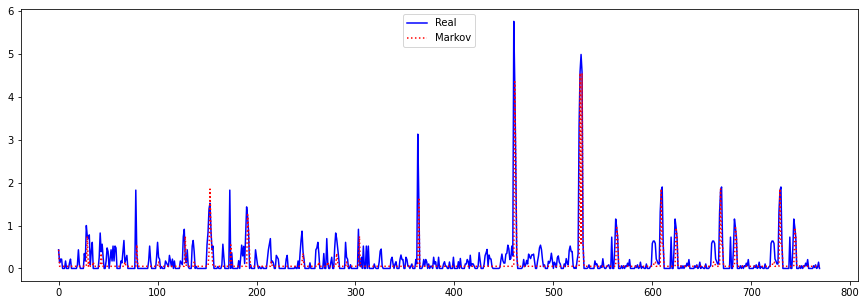

In [6]:
x_axis = np.arange(dsize)
modeled = datalist[:1]
# predicted = observed_states[:-1].tolist()

for x in x_axis[:-1]:
    # get the previous state from observed_states
    last_state = observed_states[x]
    next_state = np.argmax(markov[last_state])
    # predict, transform state to real value (avg of end point)
    prediction = map_func(next_state)
    modeled = np.concatenate([modeled, np.array([prediction])])

plt.figure(figsize=(15,5))
plt.plot(x_axis, datalist, color="b", label="Real")
plt.plot(x_axis, modeled, color="r", linestyle="dotted", label="Markov")
plt.legend(loc=9)

# Random walks on Markov Graph

show one random walk in the future + its log-probability (not pure probability to avoid underflow)

CPU times: total: 1min 13s
Wall time: 1min 16s


(720.0, 870.0)

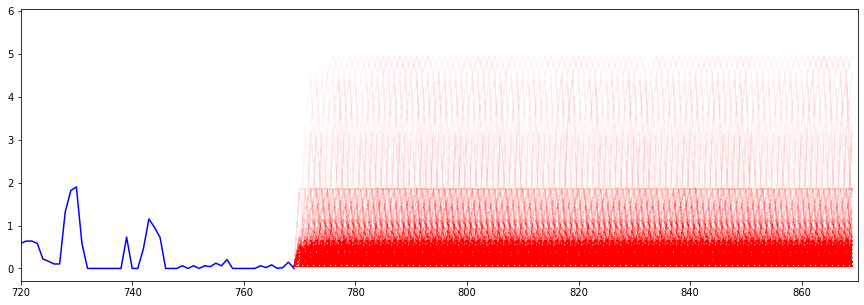

In [7]:
%%time
ahead = 100
future_x = np.arange(dsize-1, dsize + ahead)
myfig = plt.figure(figsize=(15,5))
plt.plot(x_axis, datalist, color="b")
for i in range(10000):
    walk = utils_markov.random_walk_weighted(ahead, markov, observed_states)
    plt.plot(future_x, map_func(walk['path']), color="r", linestyle='solid', alpha=0.002)
plt.xlim(dsize-50, dsize+ahead)
# plt.ylim(0.5,4.0)

In [9]:
# transition from last state to state i
n_ahead = 50
last_state = observed_states[-1]
print('Last state:', last_state)

ahead_markov = np.linalg.matrix_power(markov, n_ahead)
print('At the %d-th point in the future:' % n_ahead)
for state in states_dict.keys():
    i = int(state)
    bound = (states_dict[state][0], states_dict[state][1])
    print(f'prob -> state %d: %.2f%% in (%.{digits}f, %.{digits}f)' 
          %(i, ahead_markov[last_state][i]*100, bound[0], bound[1]))

Last state: 1
At the 50-th point in the future:
prob -> state 0: 0.00% in (-inf, 0.0)
prob -> state 1: 60.11% in (0.0, 0.1)
prob -> state 2: 11.83% in (0.1, 0.2)
prob -> state 3: 8.17% in (0.2, 0.3)
prob -> state 4: 4.28% in (0.3, 0.4)
prob -> state 5: 2.98% in (0.4, 0.5)
prob -> state 6: 3.62% in (0.5, 0.6)
prob -> state 7: 2.20% in (0.6, 0.7)
prob -> state 8: 1.55% in (0.7, 0.8)
prob -> state 9: 0.77% in (0.8, 0.9)
prob -> state 10: 0.89% in (0.9, 1.0)
prob -> state 11: 0.00% in (1.0, 1.1)
prob -> state 12: 0.50% in (1.1, 1.2)
prob -> state 13: 0.13% in (1.2, 1.3)
prob -> state 14: 0.52% in (1.3, 1.4)
prob -> state 15: 0.13% in (1.4, 1.5)
prob -> state 16: 0.13% in (1.5, 1.6)
prob -> state 17: 0.13% in (1.6, 1.7)
prob -> state 18: 0.00% in (1.7, 1.8)
prob -> state 19: 1.04% in (1.8, 1.9)
prob -> state 20: 0.00% in (1.9, 2.0)
prob -> state 21: 0.00% in (2.0, 2.1)
prob -> state 22: 0.00% in (2.1, 2.2)
prob -> state 23: 0.00% in (2.2, 2.3)
prob -> state 24: 0.00% in (2.3, 2.4)
prob -> s